## pyMACS Introduction

In [22]:
import pyMACS
from pyMACS.virtualMACS import VirtualMACS
import matplotlib.pyplot as plt
import mcstasscript as ms
import numpy as np

Welcome to a basic introduction of the pyMACS package. Here we will go through some of the basic functionality, use cases, and limitations of the package itself. Before doing anything, please make sure that 
1) You have a valid McStas 3.* installation.
2) You have installed mcstasscript and properly set up its configurator to point to your McStas installation.

After importing pyMACS, we import the VirtualMACS class in the call 
>from pyMACS.virtualMACS import VirtualMACS

The VirtualMACS class is essentially a virtual MACS experiment. It contains all of the information about the sample, the instrument, and the output data. This class is broken down into the following components:

1. VirtualMACS.monochromator, contains all instrumental settings and python methods relevant to the monochromator
2. VirtualMACS.kidney, contains all instrumental settings and python methods relevant to the 20-channel detector geometry (kidney)
3. VirtualMACS.sample, contains the sample information such as the alignment, lattice parameters, and various assosicated methods.
4. VirtualMACS.data, class that handles all input and output data of both real ng0 files and simulated data.

Let's begin by creating a simple experiment. 

In [2]:
macs = VirtualMACS(exptName='test',cifName="TiO2.cif")

#########################
Old simulations found in /mnt/c/Users/tjh/OneDrive - NIST/GitHub/pyMACS/docs/source/notebooks/test/Kidney_simulations/
 
Successfully combined old simulations into /mnt/c/Users/tjh/OneDrive - NIST/GitHub/pyMACS/docs/source/notebooks/test/Kidney_simulations/test_total.csv

Data matrix instantiated and ready to use.
#########################


Now, define sample parameters relevant to the simulation. Here, we will align the sample in the (H0L) plane. 


In [3]:
macs.sample.formula_weight=79.87
macs.sample.sample_widx=5e-3
macs.sample.sample_widz=5e-3
macs.sample.sample_widy=5e-3

#Alignment, orient_u is defined as perpendicular to the beam, orient_v is parallel
macs.sample.orient_u=[1,0,0]
macs.sample.orient_v=[0,0,1]

McStas requires lattice vector inputs in the lab frame. This function automatically performs that projection given that the orient u and v vectors have been specified. 


In [4]:
macs.sample.project_sample_realspace()
#Print the projection
labproj_h0l = macs.sample.labframe_mat
print("Projection of TiO2 lattice parameters in (H0L) plane;\nFormat is [[ax,ay,az],[bx,by,bz],[cx,cy,cz]]")
print(labproj_h0l)
#Now try reorienting the sample into the (HHL) frame:
macs.sample.orient_u=[1,1,0]
macs.sample.orient_v=[0,0,1]
macs.sample.project_sample_realspace()
#Print the projection
labproj = macs.sample.labframe_mat
print("Projection of TiO2 lattice parameters in (HHL) plane;\nFormat is [[ax,ay,az],[bx,by,bz],[cx,cy,cz]]")
print(labproj)

Projection of TiO2 lattice parameters in (H0L) plane;
Format is [[ax,ay,az],[bx,by,bz],[cx,cy,cz]]
[[4.6001 0.     0.    ]
 [0.     4.6001 0.    ]
 [0.     0.     2.9288]]
Projection of TiO2 lattice parameters in (HHL) plane;
Format is [[ax,ay,az],[bx,by,bz],[cx,cy,cz]]
[[ 3.25276 -3.25276  0.     ]
 [ 3.25276  3.25276  0.     ]
 [ 0.       0.       2.9288 ]]


There are a few more options available in the sample class, but for now this is the minimum to start a simulation.

**A key part of the achitecture of pyMACS is the definition the scattering in the sample environment**

There are two mandatory objects that must be defined and to run the simulation. They are :
1) A scattering definition, which dictates the various possible scattering processes in the sample. Common choices are incoherent scattering and single crystal Bragg scattering. More advanced options are covered later in the documentation.
2) The scattering geometry, including the sample holder. Using the UNION notation, one must specify the size and shape of the sample and its holder. Scattering processes for Aluminum have already been defined, support for more sample holder materials may be added in a future update.

In [5]:
# The scattering definition comes first
scattering_def = ms.McStas_instr("scattering_definition",checks=False)
# At launch of pyMACS, only "Incoherent_process", "Single_crystal_process",
#    and "SQW4_process" are supported. 
inc_scatter = scattering_def.add_component("inc_scatter","Incoherent_process")
inc_scatter.sigma=macs.sample.sigma_inc
inc_scatter.unit_cell_volume = macs.sample.cell_vol
inc_scatter.packing_factor = 1
inc_scatter.set_AT([0,0,0])

#Single crystal process. 
crystal_scatter = scattering_def.add_component("crystal_scatter","Single_crystal_process")
#Information about the mosaic is provided below
crystal_scatter.delta_d_d=0.005
crystal_scatter.mosaic = 30.0
#Projections of lattice vectors onto lab frame is handled by the previous helper process.
labproj = macs.sample.labframe_mat
crystal_scatter.ax = labproj[0,0]
crystal_scatter.ay = labproj[0,1]
crystal_scatter.az = labproj[0,2]
crystal_scatter.bx = labproj[1,0]
crystal_scatter.by = labproj[1,1]
crystal_scatter.bz = labproj[1,2]
crystal_scatter.cx = labproj[2,0]
crystal_scatter.cy = labproj[2,1]
crystal_scatter.cz = labproj[2,2]
# This requires a call to the function "sample.cif2lau()", which translates the input cif
macs.sample.cif2lau()
crystal_scatter.reflections='\"'+"TiO2.lau"+'\"'
crystal_scatter.barns=1
crystal_scatter.packing_factor=1
crystal_scatter.powder=0
crystal_scatter.PG=0
crystal_scatter.interact_fraction=0.8
crystal_scatter.set_AT([0,0,0])
crystal_scatter.set_ROTATED([0,0,0])

#Now, we combine these scattering processes to form a single TiO2 material
scattering = scattering_def.add_component("TiO2","Union_make_material")
scattering.process_string='"crystal_scatter,inc_scatter"'
scattering.my_absorption=macs.sample.rho_abs
scattering.set_AT([0,0,0])

#IMPORTANT: This pseudo-instrument will be saved as the scattering definition of the sample. 
macs.sample.scattering_def = scattering_def

 
Conversion of CIF to crystallographical LAU file successful. 


Now, we make a geometry object representing the sample and its holder. 

In [6]:
#Make a second object for the geometry. This particular case replicates the validation experiment for this package.
geo_def = ms.McStas_instr("geometry_definition",checks=False)

sample_cube=geo_def.add_component("sample_cube","Union_box")
sample_cube.xwidth=1.0*macs.sample.sample_widx
sample_cube.yheight=1.0*macs.sample.sample_widy
sample_cube.zdepth=1.0*macs.sample.sample_widz
sample_cube.priority=100
sample_cube.material_string='\"TiO2\"'
sample_cube.number_of_activations="number_of_activations_sample" #Do not change. 
sample_cube.set_AT([0,0,0],RELATIVE='crystal_assembly')
sample_cube.set_ROTATED([0,0,0],RELATIVE='crystal_assembly')


sample_plate = geo_def.add_component("sample_plate","Union_cylinder")
sample_plate.radius=0.006
sample_plate.yheight=0.002
sample_plate.priority=40
sample_plate.material_string='"Al"'
plate_distance = macs.sample.sample_widy+0.002
sample_plate.set_AT([0,plate_distance,0],RELATIVE="target")
sample_plate.set_ROTATED([0,0,0],RELATIVE="target")

sample_plate_rod = geo_def.add_component("sample_plate_rod","Union_cylinder")
sample_plate_rod.radius=0.00125
sample_plate_rod.yheight=0.0633
sample_plate_rod.priority=41
sample_plate_rod.material_string='"Al"'
sample_plate_rod.set_AT([0,plate_distance+0.001+0.031,0], RELATIVE="target")
sample_plate_rod.set_ROTATED([0,0,0],RELATIVE="target")

sample_base = geo_def.add_component("sample_base","Union_cylinder")
sample_base.radius=0.0065
sample_base.yheight=0.013
sample_base.priority=42
sample_base.material_string='\"Al\"'
sample_base.set_AT([0,0.0628,0],RELATIVE="target")
sample_base.set_ROTATED([0,0,0],RELATIVE="target")

sample_base_gap = geo_def.add_component("sample_base_gap","Union_cylinder")
sample_base_gap.radius=0.004
sample_base_gap.yheight=0.009
sample_base_gap.priority=43
sample_base_gap.material_string='"Vacuum"'
sample_base_gap.set_AT([0,0.0668,0], RELATIVE="target")
sample_base_gap.set_ROTATED([0,0,0],RELATIVE="target")

# IMPORTANT: Assign the geometry definition to the sample.
macs.sample.geometry_def = geo_def


While this may seem intimidating at first, this is the most difficult part of setting up the instrument. Many different sample geometries can be built up using the mcstasscript language, the backend of the MACS simulation is constructed in this way.

### Define parameters relevant to the McStas simulation:

There are a number of attributes of the virtualMACS object that dictate the Monte-Carlo simulation parameters. 

By default, McStas will create a new directory in the project folder containing all of the necessary files for the experiment. If the "useOld" option is flagged as true, the object will attempt to load in all previous simulated results. It will also preserve the directory, instead of deleting it and overwriting it with new files.

In [7]:
# It is usually a good idea to leave this flag as True, however if you want to 
# start from scratch it can be a good idea to make it False. 
macs.useOld=True

if macs.useOld==True:
    macs.useOld=True
    macs.prepare_expt_directory()
else:
    macs.data.data_matrix=False
    # prepare_expt_directory populates the a folder in the base directory with all necessary files
    # to perform the simulation.
    macs.prepare_expt_directory()
    #The below command write the McStas .instr file for the full MACS simulation based on the 
    # user-provided definitions above
    macs.edit_instr_file()
    macs.compileMonochromator()
    macs.compileInstr()


/mnt/c/Users/tjh/OneDrive - NIST/GitHub/pyMACS/docs/source/notebooks
#################

Starting compilation of monochromator.

Compilation of monochromator geometry successful.

#################

#################

Starting compilation of monochromator.

Compilation of monochromator geometry successful.

#################



All of the relevant McStas files have now been prepared, it may be instructive to browse them in 
>exptName/Instrument files/

We assign a few more parameters relevant to the simulation. Here we are doing the simplest possible scan, which is defining a single instrumental configuration and running.

## Assign Instrument Parameters
In this example, we use Ei=5meV = Ef

In [9]:
macs.monochromator.Ei=9.078
macs.kidney.Ef=9.078
macs.A3_angle = 67.37
macs.kidney.kidney_angle=3.0

macs.runMonoScan()
csvname = macs.runKidneyScan()

print(f"Scan complete. Saved to {csvname}.")

Scan complete. Saved to test_Ei_9.078_Ef_9.078_A3_67.3700_kidney_3.0000_dataMatrix.csv.


Simulation results live in the VirtualMACS.data.data_matrix, which is a pandas dataframe containing all simulation results. Results are also written to .csv files and .ng0 files which can be found in the simulation directory.

There are a number of useful methods here for exporting and importing data. We start by loading the result of the previous scan, and appending it to the data matrix. We can also write it to an ng0 file to examine in DAVE, if you are more comfortable in that environment.

In [17]:
#The files are saved as csv's for now, add to the data_matrix manually.
# The replace is due to a bad naming convention that I plan to fix in a future update.
macs.data.load_data_matrix_from_csv(csvname.replace(macs.exptName,''))
# Save this to a DAVE-readable ng0 file. 
macs.data.write_data_to_ng0(filename='test.ng0')

1

We can use the built in tools to visualize the data below:

Text(0.5, 1.0, 'TiO2 A3 Scan, Elastic')

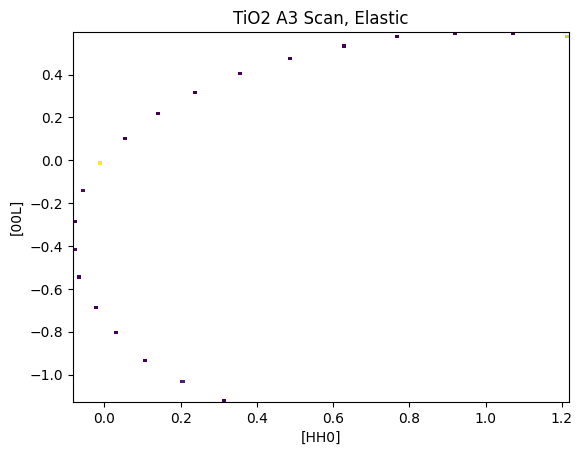

In [19]:
# The data must be converted from detector numbers and angles to the sample frame. 
macs.data.project_data_QE()
U,V,I = macs.data.bin_constE_slice(120,120,[-2,2],[-2,2],[-1,1])

plt.figure()
plt.pcolormesh(U,V,I.T,vmin=0,vmax=20)
plt.xlabel('[HH0]')
plt.ylabel('[00L]')
plt.title("TiO2 A3 Scan, Elastic")


As expected, a single scan won't do much good to visualize sample scattering. Below is an example showing a scripted A3/A4 scan.

This method automatically appends the calculations to the data_matrix.

In [ ]:
#The parameters n_sample and n_mono are the number of Monte-Carlo counts for the 
# sample end and the monochromator end of the simulation respectively. It is usually
# appropriate for n_mono=10*n_sample. 
macs.n_sample=1e5
macs.n_mono = 1e6
macs.kidney.Ef=5.0
#The parameter below is the A4 / twoTheta resolution. The Kidney angles are generated 
# identically to MACS from this.
macs.kidney_angle_resolution=0.7
macs.preserve_kidney_scan_files=False
# pyMACS natively supports multithreading through joblib threading. 
macs.script_scan(A3_list=np.arange(-70,-20,0.2),Ei_list=[5.0],\
                    num_threads=8,scan_title='_tio2_a3scan_cube')

Total Scans:   0%|          | 0/1 [00:00<?, ?it/s]

Ei=5.0 meV:   0%|          | 0/14 [00:00<?, ?it/s]